In [98]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

from pylab import *
from pyspark.sql.functions import udf, concat, col, lit
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

In [99]:
df = spark.read.format("csv").option("header", "true").load('/content/waterquality.csv')
gdf = gpd.read_file('/content/india-states/Igismap/Indian_States.shp')

In [100]:
df.show(5)


+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|  8|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

In [101]:
df.dtypes


[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'string'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

In [102]:
from pyspark.sql.types import FloatType
df = df.withColumn("TEMP",df["TEMP"].cast(FloatType()))
df = df.withColumn("pH",df["pH"].cast(FloatType()))
df = df.withColumn("DO",df["DO"].cast(FloatType()))
df = df.withColumn("CONDUCTIVITY",df["CONDUCTIVITY"].cast(FloatType()))
df = df.withColumn("BOD",df["BOD"].cast(FloatType()))
df = df.withColumn("NITRATE_N_NITRITE_N",df["NITRATE_N_NITRITE_N"].cast(FloatType()))
df = df.withColumn("FECAL_COLIFORM",df["FECAL_COLIFORM"].cast(FloatType()))
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'string')]

In [103]:
df=df.drop('TOTAL_COLIFORM')
df=df.drop('BOD')
df=df.drop('FECAL_COLIFORM')


In [104]:
df.createOrReplaceTempView("df_sql")


In [105]:
df_clean = spark.sql('''Select * from df_sql where TEMP is not null and DO is not null
                        and pH is not null and CONDUCTIVITY is not null
                        and NITRATE_N_NITRITE_N is not null''')

In [106]:
df_clean.createOrReplaceTempView("df_sql")


In [107]:

do = spark.sql("Select DO from df_sql")
do = do.rdd.map(lambda row : row.DO).collect()
ph = spark.sql("Select pH from df_sql")
ph = ph.rdd.map(lambda row : row.pH).collect()
CONDUCTIVITY = spark.sql("Select CONDUCTIVITY from df_sql")
CONDUCTIVITY = CONDUCTIVITY.rdd.map(lambda row : row.CONDUCTIVITY).collect()
nn = spark.sql("Select NITRATE_N_NITRITE_N from df_sql")
nn = nn.rdd.map(lambda row : row.NITRATE_N_NITRITE_N).collect()

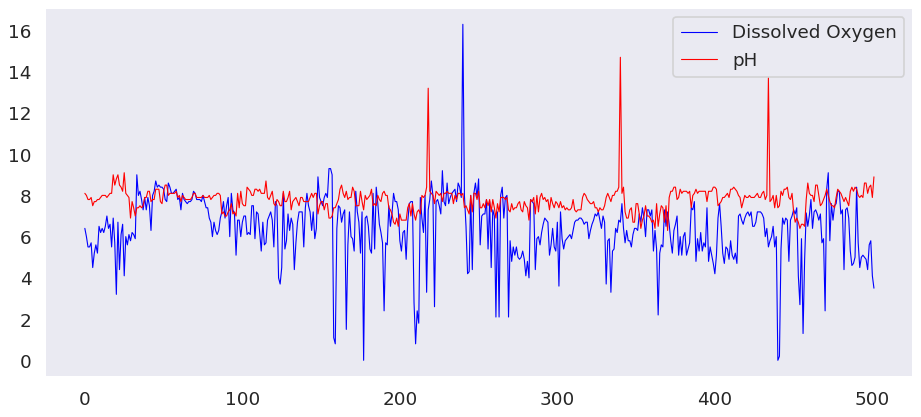

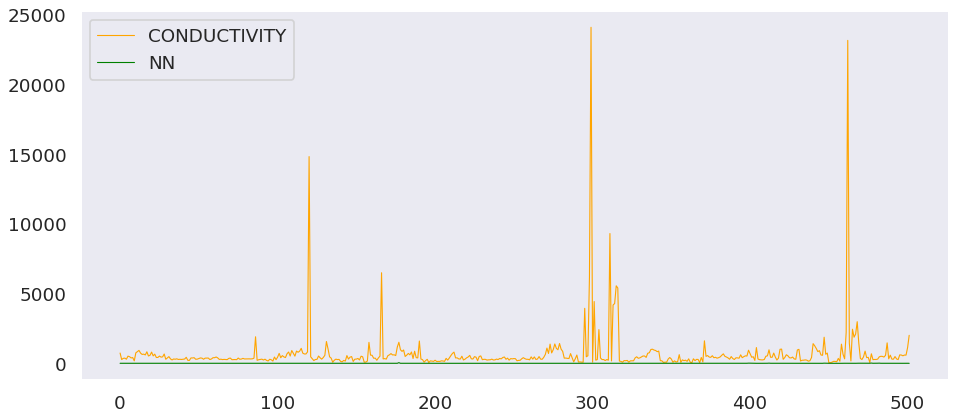

In [108]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
size=len(do)
ax.plot(range(0,size), do, color='blue', animated=True, linewidth=1, label='Dissolved Oxygen')
ax.plot(range(0,size), ph, color='red', animated=True, linewidth=1, label='pH')
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), CONDUCTIVITY, color='orange', animated=True, linewidth=1, label='CONDUCTIVITY')
ax2.plot(range(0,size), nn, color='green', animated=True, linewidth=1, label='NN')
legend=ax.legend()
legend=ax2.legend()

In [109]:

df=df_clean.toPandas()
df.dtypes

,0
STATION CODE,object
LOCATIONS,object
STATE,object
TEMP,float32
DO,float32
pH,float32
CONDUCTIVITY,float32
NITRATE_N_NITRITE_N,float32


In [110]:
print(df.shape)
start=0
end=448
station=df.iloc [start:end ,0]
location=df.iloc [start:end ,1]
state=df.iloc [start:end ,2]
do= df.iloc [start:end ,4].astype(np.float64)
value=0
ph = df.iloc[ start:end,5]
co = df.iloc [start:end ,6].astype(np.float64)
na= df.iloc [start:end ,7].astype(np.float64)


(502, 8)


In [111]:
df=pd.concat([station,location,state,do,ph,co,na],axis=1)
df. columns = ['station','location','state','do','ph','co','na']

In [112]:
df['npH']=df.ph.apply(lambda x: (100 if (8.5>=x>=7)
                                 else(80 if  (8.6>=x>=8.5) or (6.9>=x>=6.8)
                                      else(60 if (8.8>=x>=8.6) or (6.8>=x>=6.7)
                                          else(40 if (9>=x>=8.8) or (6.7>=x>=6.5)
                                              else 0)))))

In [113]:
df['ndo']=df.do.apply(lambda x:(100 if (x>=6)
                                 else(80 if  (6>=x>=5.1)
                                      else(60 if (5>=x>=4.1)
                                          else(40 if (4>=x>=3)
                                              else 0)))))

In [114]:
df['nec']=df.co.apply(lambda x:(100 if (75>=x>=0)
                                 else(80 if  (150>=x>=75)
                                      else(60 if (225>=x>=150)
                                          else(40 if (300>=x>=225)
                                              else 0)))))

In [115]:
df['nna']=df.na.apply(lambda x:(100 if (20>=x>=0)
                                 else(80 if  (50>=x>=20)
                                      else(60 if (100>=x>=50)
                                          else(40 if (200>=x>=100)
                                              else 0)))))

df.head()
df.dtypes

,0
station,object
location,object
state,object
do,float64
ph,float32
co,float64
na,float64
npH,int64
ndo,int64
nec,int64


In [116]:

df['wph']=df.npH * 0.165
df['wdo']=df.ndo * 0.281
df['wec']=df.nec* 0.009
df['wna']=df.nna * 0.028
df['wqi']=df.wph+df.wdo+df.wec+df.wna
df

,station,location,state,do,ph,co,na,npH,ndo,nec,nna,wph,wdo,wec,wna,wqi
0,1312,"GODAVARI AT JAYAKWADI DAM, AURNAGABAD,MAHARASHTRA",MAHARASHTRA,6.4,8.1,735.0,2.00,100,100,0,100,16.5,28.10,0.00,2.8,47.40
1,2177,GODAVARI RIVER NEAR SOMESHWAR TEMPLE.,MAHARASHTRA,6.0,8.0,270.0,2.00,100,100,40,100,16.5,28.10,0.36,2.8,47.76
2,2182,GODAVARI RIVER AT SAIKHEDA.,MAHARASHTRA,5.5,7.8,355.0,9.00,100,80,0,100,16.5,22.48,0.00,2.8,41.78
3,2179,"GODAVARI RIVER AT HANUMAN GHAT, NASHIK CITY.",MAHARASHTRA,5.5,7.8,371.0,3.55,100,80,0,100,16.5,22.48,0.00,2.8,41.78
4,2183,GODAVARI RIVER AT NANDUR- MADMESHWAR DAM.,MAHARASHTRA,5.7,7.9,294.0,2.69,100,80,40,100,16.5,22.48,0.36,2.8,42.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,1178,"PALLERU BEFORE CONFL. WITH KRISHNA, JAGGAYYAPE...",ANDHRA PRADESH,6.9,8.0,838.0,0.60,100,100,0,100,16.5,28.10,0.00,2.8,47.40
444,1177,"MUNERU BEFORE CONFL. WITH KRISHNA, NANDIGAMA, ...",ANDHRA PRADESH,6.6,8.3,905.0,0.50,100,100,0,100,16.5,28.10,0.00,2.8,47.40
445,1895,KAGINA D/S OF SEWAGE DISPOSAL POINT,KARNATAKA,6.9,8.3,596.0,0.30,100,100,0,100,16.5,28.10,0.00,2.8,47.40
446,2777,"KAGINA AT SHAHABAD BRIDGE, KARNATAKA",KARNATAKA,6.8,8.4,575.0,0.40,100,100,0,100,16.5,28.10,0.00,2.8,47.40


In [117]:
df['quality']=df.wqi.apply(lambda x:('Excellent' if (25>=x>=0)
                                 else('Good' if  (50>=x>=26)
                                      else('Poor' if (75>=x>=51)
                                          else('Very Poor' if (100>=x>=76)
                                              else 'Unsuitable')))))

In [118]:
#renaming state names
gdf['st_nm'].replace({"Andaman & Nicobar Island": "Andaman and Nicobar Islands",
                      "Arunanchal Pradesh": "Arunachal Pradesh",
                      'Dadara & Nagar Havelli':'Dadra and Nagar Haveli and Daman and Diu',
                      'Jammu & Kashmir':'Jammu and Kashmir',
                      'NCT of Delhi':'Delhi'}, inplace=True)
df['state'].replace({"TAMILNADU": "TAMIL NADU"}, inplace=True)

#Capitalizing only the first letter of each word
df['state'] = df['state'].str.title()

In [119]:
!pip install mapclassify

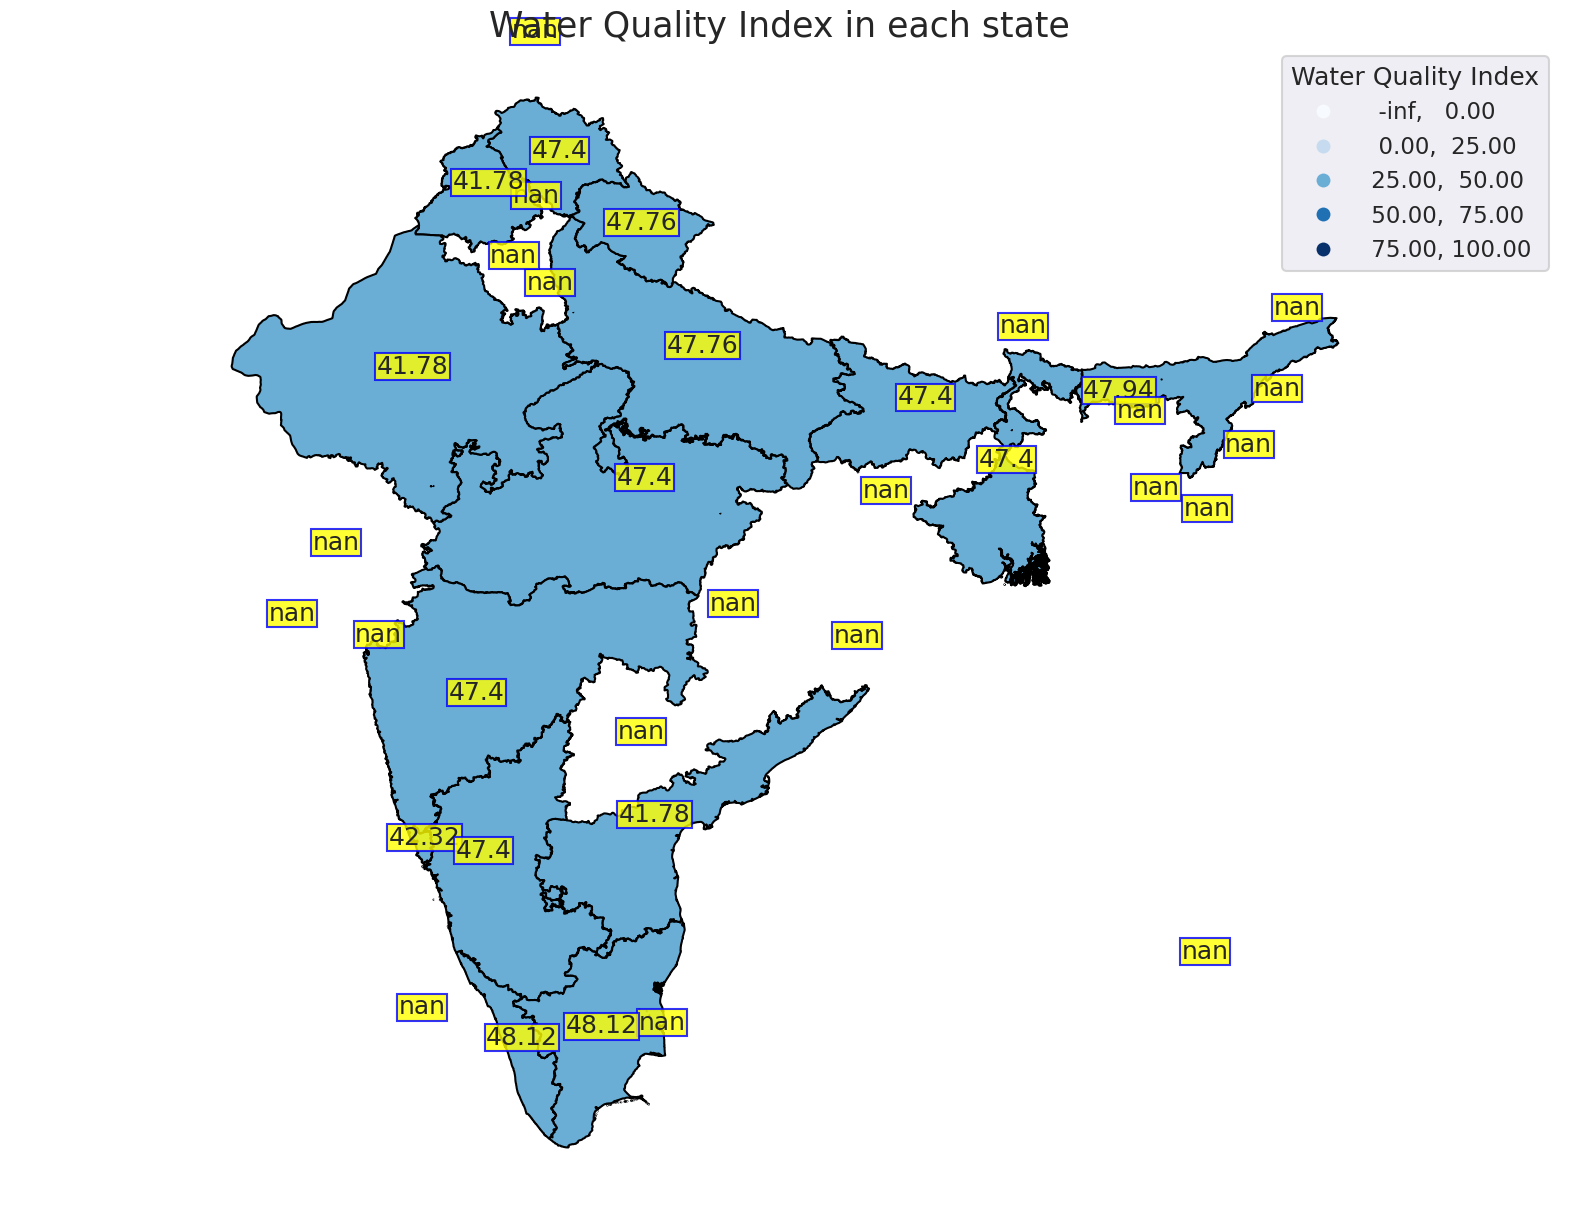

In [120]:
gdf = gdf.rename(columns={"st_nm": "state"})
merged = pd.merge(gdf, df , how='outer', on='state')
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged = merged.drop_duplicates(subset ="state")

sns.set_context("talk")
sns.set_style("dark")
cmap = 'Blues'
figsize = (20, 15)
ax = merged.plot(column= 'wqi', cmap=cmap,
                          figsize=figsize, scheme='User_Defined',
                          classification_kwds=dict(bins=[0,25,50,75,100]),
                          edgecolor='black', legend = True)
for idx, row in merged.iterrows():
    ax.text(row.coords[0], row.coords[1], s=row['wqi'], horizontalalignment='center', bbox={'facecolor': 'yellow', 'alpha':0.8, 'pad': 1, 'edgecolor':'blue'})

ax.get_legend().set_title('Water Quality Index')
ax.set_title("Water Quality Index in each state ", size = 25)

ax.set_axis_off()
plt.axis('equal')
plt.show()

In [121]:
spark_df = sqlContext.createDataFrame(df)


In [122]:
spark_df.show()


+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+---+---+---+---+------------------+------------------+------------------+------------------+-----+-------+
|station|            location|         state|               do|               ph|   co|                na|npH|ndo|nec|nna|               wph|               wdo|               wec|               wna|  wqi|quality|
+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+---+---+---+---+------------------+------------------+------------------+------------------+-----+-------+
|   1312|GODAVARI AT JAYAK...|   Maharashtra|6.400000095367432|8.100000381469727|735.0|               2.0|100|100|  0|100|              16.5|              28.1|               0.0|2.8000000000000003| 47.4|   Good|
|   2177|GODAVARI RIVER NE...|   Maharashtra|              6.0|              8.0|270.0|               2.0|100|100| 40|100|              16.5|       

In [123]:
spark_df.createOrReplaceTempView("df_sql")


In [124]:
State = spark.sql("Select state from df_sql")
State = State.rdd.map(lambda row : row.state).collect()

In [125]:

Wqi = spark.sql("Select wqi from df_sql")
Wqi = Wqi.rdd.map(lambda row : row.wqi).collect()

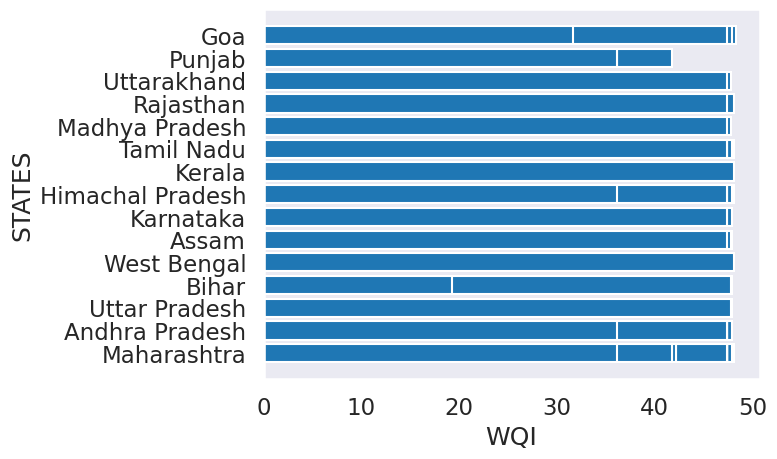

In [126]:

plt.barh(State,Wqi)

plt.xlabel("WQI")
plt.ylabel("STATES")


plt.show()

In [127]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

vectorAssembler = VectorAssembler(inputCols=["npH","ndo","nec","nna"], outputCol="features")
normalizer = Normalizer(inputCol="features",outputCol="features_norm")

In [128]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

vectorAssembler = VectorAssembler(inputCols=["npH","ndo","nec","nna"], outputCol="features")
normalizer = Normalizer(inputCol="features",outputCol="features_norm")

In [129]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features_norm",labelCol="wqi",maxIter=10,regParam=0.3,elasticNetParam=0.2)

In [130]:
from pyspark.ml import Pipeline


In [131]:
pipeline = Pipeline(stages=[vectorAssembler,normalizer,lr])


In [132]:
train_data,test_data=spark_df.randomSplit([0.8,0.2])


In [133]:
model = pipeline.fit(train_data)


In [134]:
predictions = model.transform(train_data)


In [135]:
predictions.select("wqi","prediction").show()


+-----+-----------------+
|  wqi|       prediction|
+-----+-----------------+
| 47.4|46.98001317108244|
|47.76|46.95591193433976|
| 47.4|46.98001317108244|
| 47.4|46.98001317108244|
| 47.4|46.98001317108244|
| 47.4|46.98001317108244|
|47.76|46.95591193433976|
|47.76|46.95591193433976|
| 47.4|46.98001317108244|
| 47.4|46.98001317108244|
| 47.4|46.98001317108244|
| 47.4|46.98001317108244|
| 47.4|46.98001317108244|
| 47.4|46.98001317108244|
| 47.4|46.98001317108244|
| 47.4|46.98001317108244|
|47.94| 46.9489089733264|
| 47.4|46.98001317108244|
|47.76|46.95591193433976|
|47.94| 46.9489089733264|
+-----+-----------------+
only showing top 20 rows



In [ ]:
model.stages[2].summary.r2







0.9769264945985368

In [ ]:
!pip uninstall pyPMML

Found existing installation: pypmml 1.5.4
Uninstalling pypmml-1.5.4:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/pypmml-1.5.4.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pypmml/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 364, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 404, in

In [ ]:
!pip install pyPMML



In [ ]:
from pyPMML import Model
from pyPMML import Field, DataDictionary, RegressionModel, NumericPredicate

# Define the fields (input variables)
fields = [Field(name='npH', dataType='double'),
          Field(name='ndo', dataType='double'),
          Field(name='nec', dataType='double'),
          Field(name='nna', dataType='double')]

# Define the target field (output variable)
output_field = Field(name='wqi', dataType='double')

# Create a data dictionary with the input and output fields
data_dict = DataDictionary(fields + [output_field])

# Define the regression model (example for linear regression)
reg_model = RegressionModel(modelName="LinearRegression", functionName="regression", targetField='wqi')

# Set coefficients and intercept
reg_model.addNumericPredictor(name="npH", coefficient=coefficients[0])
reg_model.addNumericPredictor(name="ndo", coefficient=coefficients[1])
reg_model.addNumericPredictor(name="nec", coefficient=coefficients[2])
reg_model.addNumericPredictor(name="nna", coefficient=coefficients[3])
reg_model.setIntercept(intercept)

# Create the full PMML model
pmml_model = Model(dataDict=data_dict, model=reg_model)

# Save the PMML model to a file
pmml_model.save("linear_regression_model.pmml")


ModuleNotFoundError: No module named 'pyPMML'